# Новый раздел

In [ ]:
!kaggle datasets download -d shubhamgoel27/dermnet #download the dataset form Kaggle

In [ ]:
!unzip dermnet.zip  -d dermnet


In [ ]:
!ls dermnet/train

'Acne and Rosacea Photos'
'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions'
'Atopic Dermatitis Photos'
'Bullous Disease Photos'
'Cellulitis Impetigo and other Bacterial Infections'
'Eczema Photos'
'Exanthems and Drug Eruptions'
'Hair Loss Photos Alopecia and other Hair Diseases'
'Herpes HPV and other STDs Photos'
'Light Diseases and Disorders of Pigmentation'
'Lupus and other Connective Tissue diseases'
'Melanoma Skin Cancer Nevi and Moles'
'Nail Fungus and other Nail Disease'
'Poison Ivy Photos and other Contact Dermatitis'
'Psoriasis pictures Lichen Planus and related diseases'
'Scabies Lyme Disease and other Infestations and Bites'
'Seborrheic Keratoses and other Benign Tumors'
'Systemic Disease'
'Tinea Ringworm Candidiasis and other Fungal Infections'
'Urticaria Hives'
'Vascular Tumors'
'Vasculitis Photos'
'Warts Molluscum and other Viral Infections'


In [ ]:
!pip install fvcore=='0.1.dev200114'

In [ ]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import seaborn as sns
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import itertools
import logging
from typing import Any, Dict, Iterable, List, Optional, Tuple, Type
import tqdm

from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import fvcore
from fvcore.nn.precise_bn import update_bn_stats

import argparse
import sys
import datetime
import math
import json
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mp_image
from sklearn.metrics import confusion_matrix
import seaborn as sns

from PIL import Image
import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
from torchvision import models as torchvision_models
torch.cuda.empty_cache()

DIR = "dermnet"
DIR_TRAIN = "dermnet/train/"
DIR_TEST = "dermnet/test/"

In [ ]:
# Exploring Dataset

classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes))

#Counting total train, valid & test images

train_count = 0
valid_count = 0
test_count = 0

classes_df = []
for _class in classes:
    class_dict = {}
    train_count += len(os.listdir(DIR_TRAIN + _class))
    test_count += len(os.listdir(DIR_TEST + _class))
    #print(f'Class {_class}: train amount {train_count}, test amount {test_count} ')
    class_dict.update({'Class': _class, 'Train': len(os.listdir(DIR_TRAIN + _class)), 'Test': len(os.listdir(DIR_TEST + _class)) })
    classes_df.append(class_dict)

print("Total train images: ",train_count)
print("Total test images: ",test_count)
print(pd.DataFrame(classes_df))

Total Classes:  23
Total train images:  15557
Total test images:  4002
                                                Class  Train  Test
0                             Acne and Rosacea Photos    840   312
1   Actinic Keratosis Basal Cell Carcinoma and oth...   1149   288
2                            Atopic Dermatitis Photos    489   123
3                              Bullous Disease Photos    448   113
4   Cellulitis Impetigo and other Bacterial Infect...    288    73
5                                       Eczema Photos   1235   309
6                        Exanthems and Drug Eruptions    404   101
7   Hair Loss Photos Alopecia and other Hair Diseases    239    60
8                    Herpes HPV and other STDs Photos    405   102
9        Light Diseases and Disorders of Pigmentation    568   143
10         Lupus and other Connective Tissue diseases    420   105
11                Melanoma Skin Cancer Nevi and Moles    463   116
12                 Nail Fungus and other Nail Disease   10

In [ ]:
# Creating a list of all images : DIR_TRAIN/class_folder/img.jpg 
#   A dict for mapping class labels to index

train_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)
    
    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(DIR_TEST + _class + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}

In [ ]:
class_to_int

{'Acne and Rosacea Photos': 0,
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1,
 'Atopic Dermatitis Photos': 2,
 'Bullous Disease Photos': 3,
 'Cellulitis Impetigo and other Bacterial Infections': 4,
 'Eczema Photos': 5,
 'Exanthems and Drug Eruptions': 6,
 'Hair Loss Photos Alopecia and other Hair Diseases': 7,
 'Herpes HPV and other STDs Photos': 8,
 'Light Diseases and Disorders of Pigmentation': 9,
 'Lupus and other Connective Tissue diseases': 10,
 'Melanoma Skin Cancer Nevi and Moles': 11,
 'Nail Fungus and other Nail Disease': 12,
 'Poison Ivy Photos and other Contact Dermatitis': 13,
 'Psoriasis pictures Lichen Planus and related diseases': 14,
 'Scabies Lyme Disease and other Infestations and Bites': 15,
 'Seborrheic Keratoses and other Benign Tumors': 16,
 'Systemic Disease': 17,
 'Tinea Ringworm Candidiasis and other Fungal Infections': 18,
 'Urticaria Hives': 19,
 'Vascular Tumors': 20,
 'Vasculitis Photos': 21,
 'Warts Molluscum and other Viral Inf

In [ ]:
int_to_class =dict(map(reversed, class_to_int.items()))
int_to_class[9]

'Light Diseases and Disorders of Pigmentation'

In [ ]:
train_dataset = ImageFolder(root = DIR_TRAIN, transform=transforms.Compose([
    transforms.RandomRotation([-8,+8]),                                           # if augmentation
    transforms.ColorJitter(brightness=0, contrast=0.4, saturation=0, hue=0),      # if augmentation
    transforms.RandomHorizontalFlip(),                                            # if augmentation
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))
test_dataset = ImageFolder(root = DIR_TEST, transform=transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

In [ ]:
test_size = int(0.5 * len(test_dataset))
valid_size = len(test_dataset) - test_size
valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [valid_size, test_size])

In [ ]:
# Create training and validation dataloaders
dataloaders_dict = {}
dataloaders_dict['train'] = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
dataloaders_dict['val'] = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=False)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=False)

In [ ]:
# Set up the folder where the images are
src_folder = 'dermnet/train'

# Set up a figure of an appropriate size
fig = plt.figure(figsize=(15, 35))

# loop through the subfolders
for root, folders, filenames in os.walk(src_folder):
    image_num = 0
    num_folders = len(folders)
    for folder in sorted(folders):
        # Keep an incrementing count of each image
        image_num +=1
        # Find the image file in the folder
        file_name = os.listdir(os.path.join(root,folder))[8]
        # Get the full path from the root folder
        file_path = os.path.join(root,folder, file_name)
        # Open the file using the matplotlib.image library
        image = mp_image.imread(file_path)
        # Add the image to the figure (which will have a row for each folder, each containing 3 column for the image)
        a = fig.add_subplot(num_folders, 3, image_num)
        # Add the image to the plot
        image_plot = plt.imshow(image)
        # Add a caption with the folder name
        a.set_title(folder)
        
# Adjust vertical space
fig.subplots_adjust(hspace=1, wspace=1)
        
# Show the plot
plt.show()

In [ ]:
# Number of classes in the dataset
num_classes = 23

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True
input_size = 224

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:               
                model.eval()   # Set model to evaluate mode
                #update_bn_stats(model=model, data_loader=dataloaders[phase])  # if update_bn_stats
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                      # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

               # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
   
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def test_model(model, dl, normalize=True):
  model.eval()
  true_labels = []
  predictions = []
  total = 0
  num_correct = 0
  with torch.no_grad():
      for images, labels in dl:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          predicted = torch.argmax(outputs.data,-1)        
          true_labels.append(labels.cpu().numpy())
          predictions.append(predicted.cpu().numpy())
          total += labels.size(0)
          num_correct += (predicted == labels).sum()
      print(f"Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}")    
      true_labels = np.hstack(true_labels)
      predictions = np.hstack(predictions)
      
  return true_labels, predictions

In [ ]:
# x, y - find the img from class x labelled as class y 
def test(model, dl, x, y, normalize=True):
  model.eval()
  true_labels = []
  predictions = []
  images_list = []

  with torch.no_grad():
      for images, labels in dl:
          images_list.append(images.cpu().numpy())
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          predicted = torch.argmax(outputs.data,-1)        
          true_labels.append(labels.cpu().numpy())
          predictions.append(predicted.cpu().numpy())
    
  for n in range(60):
    for i in range(32):
      if (true_labels[n][i] == x)  & (predictions[n][i] == y):
        #inv_tensor = inv_normalize(image_list[n][i]])
        plt.imshow(np.transpose(images_list[n][i], (1, 2, 0)))
        plt.show()

###Resnet50, pretrained, 100 epochs + augmentation: RandomRotation(), ColorJitter(), RandomHorizontalFlip().

In [ ]:
# Number of epochs to train for
num_epochs = 100

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 23, bias=True)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [ ]:
# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

In [ ]:
torch.save(model.state_dict(), 'Resnet50pretrained_100epoch_v3_8')

In [ ]:
model.load_state_dict(torch.load('Resnet50pretrained_100epoch_v3_8'))

Test Accuracy of the model: 64.17


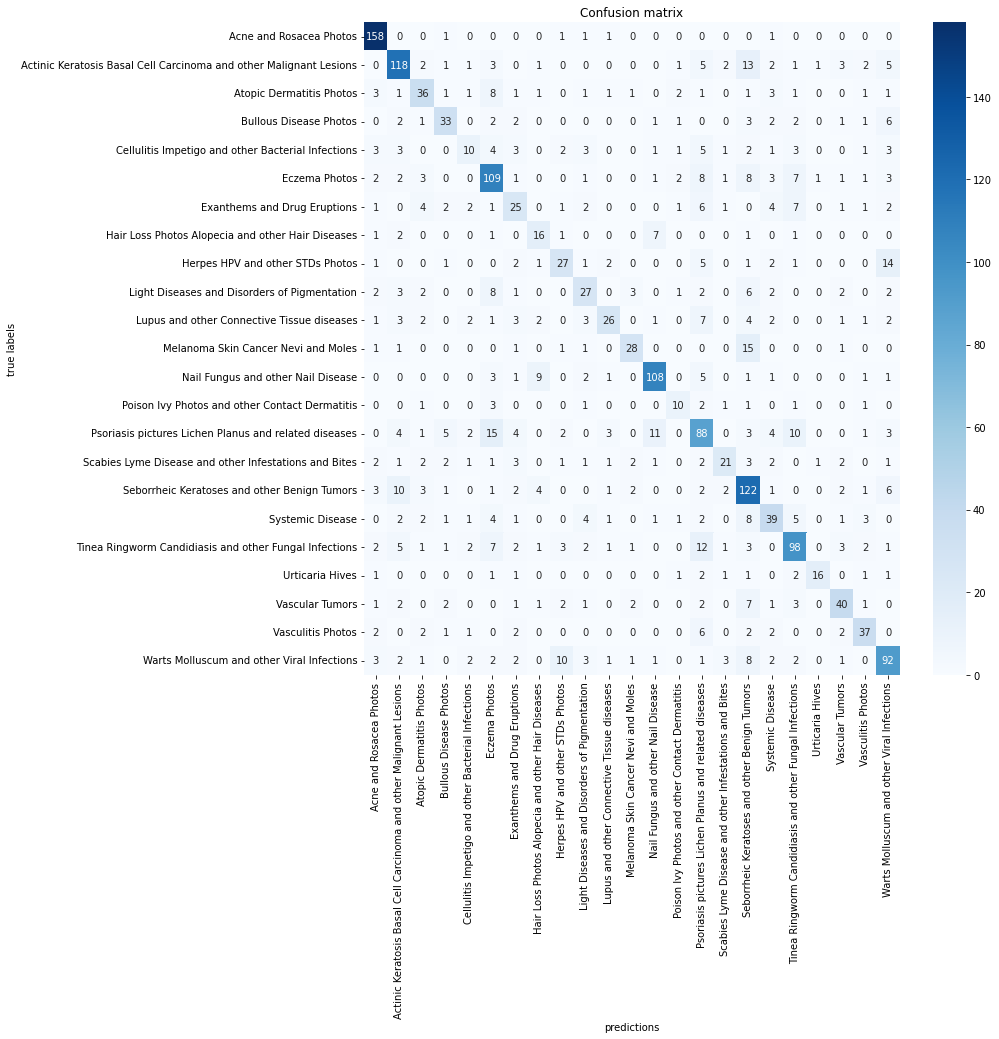

In [ ]:
true_labels, predictions = test_model(model, dataloader_test, normalize=True)
c_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(12, 12))
plt.title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='g', cbar=True)
plt.xlabel('predictions')
plt.ylabel('true labels')
plt.show()

In [ ]:
# False pediction
test(model, dataloader_test, 5, 14)

In [ ]:
# Correct pediction of 'Eczema Photos'
test(model, dataloader_test, 5, 5)